# Day 1 - Prelude: An Image Classification Problem

We begin the journey toward becoming ML engineers by exploring the MNIST dataset, which contains 70 000 handwritten digit images. Today's goal is to build a neural network that can classify each image as one of the ten digits ```0-9```, using the PyTorch framework. For this purpose, our first task is to load  dataset using `torchvision`, inspect its size, and visualize the first five samples. To start, let us quickly verify that required dependencies are installed.

In [1]:
%pip install torch torchvision matplotlib scikit-learn > out.log 2>&1

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Load MNIST dataset
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
# Set random seeds for reproducibility
import random
import numpy as np

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# If using CUDA, also set the seed for GPU operations
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

## Why set random seeds?

When prototyping machine learning models, setting a random seed is crucial for **reproducibility**:

### Why Randomness Exists in ML:
1. **Weight initialization**: Neural network weights are randomly initialized
2. **Data shuffling**: Training data order is randomized each epoch
3. **Dropout & augmentation**: Various stochastic techniques use randomness
4. **Optimizer behavior**: Some optimizers have random elements

### Why This Matters:
- **Debugging**: Without a seed, different runs give different results, making it hard to identify real bugs vs. random variance
- **Collaboration**: Team members can't verify your results without reproducibility
- **Experimentation**: You can't tell if changes to hyperparameters actually help or if results changed by chance
- **Publication**: Research requires reproducible results

### Setting Seeds Across Libraries:
- `random.seed(SEED)`: Python's built-in random number generator
- `np.random.seed(SEED)`: NumPy random operations
- `torch.manual_seed(SEED)`: PyTorch CPU operations
- `torch.cuda.manual_seed_all(SEED)`: PyTorch GPU operations (if using CUDA)

Once a seed is set, every run will produce identical results, allowing you to focus on whether your changes actually improve the model.

The MNIST dataset is a large collection of handwritten digit images (0-9), 
widely used for training and evaluating image processing and machine learning models. 
It contains 60,000 training images and 10,000 test images, each in grayscale at 28x28 pixels.

## What does MNIST stand for?

**MNIST** stands for **Modified National Institute of Standards and Technology**. 

The dataset was created by combining two datasets from NIST (National Institute of Standards and Technology):
- The training set contains 30,000 samples from Census Bureau employees
- The training set contains 30,000 samples from high school students

These were then "modified" by engineers at Bell Labs in the 1990s:
- Images were size-normalized to fit in 20×20 pixel bounding boxes
- Centered using center of mass
- Padded with white space to 28×28 pixels (the current standard size)

The MNIST dataset became the de facto benchmark for evaluating machine learning algorithms because it is:
- **Real-world data**: Actual handwritten digits from real people
- **Large enough**: 70,000 total samples for meaningful statistics
- **Manageable**: Small image size (28×28) allows quick training
- **Well-studied**: Extensive baseline results for comparison
- **Accessible**: Freely available and easy to load with libraries like torchvision

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

"""
Explanation:
transforms.Compose([...])
Chains multiple transformations together so they are applied in sequence to each image.

transforms.ToTensor()
Converts a PIL image or NumPy array to a PyTorch tensor and scales pixel values from [0, 255] to [0.0, 1.0].

transforms.Normalize((0.5,), (0.5,))
Normalizes the tensor:

Subtracts 0.5 from each pixel value (mean).
Divides by 0.5 (standard deviation).
This transforms pixel values from [0.0, 1.0] to [-1.0, 1.0], which helps neural networks train more efficiently.
Summary:
This transformation converts images to tensors and normalizes them to have values in the range [-1, 1].
"""

# Load the training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

"""
The MNIST dataset provided by torchvision.datasets.MNIST is already split into training and test sets by default.

Explanation of the code:
train=True loads the training set (60,000 images).
train=False loads the test set (10,000 images).
"""

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 60000
Test set size: 10000


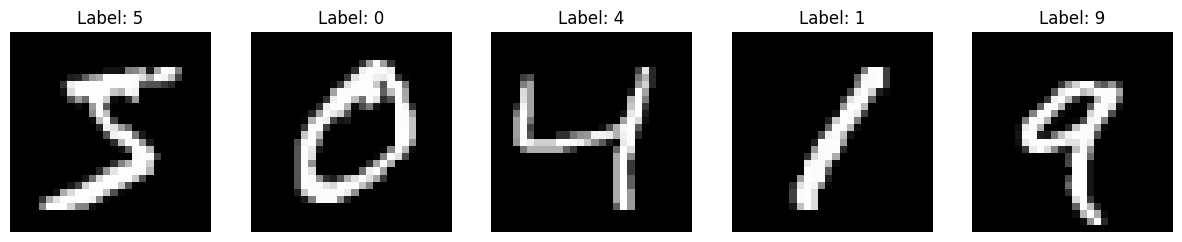

In [5]:
# Visualize the first 5 samples
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(train_dataset[i][0].squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {train_dataset[i][1]}")
    axes[i].axis('off')
plt.show()

In [9]:
# Create DataLoader objects for training and testing
from torch.utils.data import DataLoader

# Create DataLoader objects for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

"""
Explanation:

batch_size controls how many samples are loaded per batch (adjust as needed).
shuffle=True randomizes the training data order each epoch for better training.
shuffle=False keeps the test data order fixed.
You can now use train_loader and test_loader in your training and evaluation loops.
"""
print("Data loaders created successfully.")

Data loaders created successfully.


# First MLP model

- Define a simple 2-layer MLP (Multi-Layer Perceptron) in PyTorch using `nn.Module`
- Input: 28x28 pixels → Flatten to 784
- Hidden Layer: 128 neurons + ReLU
- Output Layer: 10 classes (digits 0-9)

In [10]:
import torch.nn as nn

class MNISTClassifier_MLP(nn.Module):
    def __init__(self):
        super(MNISTClassifier_MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)   # Input layer to hidden layer
        self.relu = nn.ReLU()                # Rectified Linear Unit activation - fancy name for f(x) := (x>0 ? x : 0)
        self.fc2 = nn.Linear(128, 10)        # Hidden layer to output layer (10 classes)

    def forward(self, x):
        x = self.flatten(x)         # Flatten 28x28 to 784
        x = self.fc1(x)             # Apply first linear layer
        x = self.relu(x)            # Apply ReLU activation
        x = self.fc2(x)             # Apply second linear layer
        return x

mNISTClassifier_MLP = MNISTClassifier_MLP()
for name, param in mNISTClassifier_MLP.named_parameters():
    if param.requires_grad:
        print(f"Trainable parameter: {name}, Size: {param.data.size()}")
        print(f"Parameter values: {param.data}")
    else:
        print(f"Non-trainable parameter: {name}, Size: {param.data.size()}")
        print(f"Parameter values: {param.data}")

Trainable parameter: fc1.weight, Size: torch.Size([128, 784])
Parameter values: tensor([[-0.0031,  0.0284, -0.0249,  ..., -0.0278, -0.0022,  0.0229],
        [ 0.0264,  0.0010, -0.0084,  ..., -0.0014,  0.0191,  0.0103],
        [ 0.0338, -0.0281,  0.0209,  ...,  0.0126,  0.0351, -0.0313],
        ...,
        [-0.0181, -0.0166,  0.0133,  ..., -0.0298,  0.0070, -0.0010],
        [ 0.0277, -0.0310,  0.0107,  ...,  0.0341,  0.0110,  0.0113],
        [-0.0245, -0.0076,  0.0040,  ...,  0.0061,  0.0227,  0.0300]])
Trainable parameter: fc1.bias, Size: torch.Size([128])
Parameter values: tensor([-2.3294e-02,  5.7178e-03, -5.4144e-03,  9.3135e-03, -3.4434e-02,
        -1.4768e-02, -4.9255e-03,  1.0794e-03,  3.4777e-02, -3.5603e-02,
        -5.3733e-03,  3.2880e-02, -3.7751e-03,  8.8706e-03, -1.4345e-02,
        -2.4035e-02, -1.6217e-02, -5.8189e-03, -1.3106e-04,  3.3713e-02,
        -1.7677e-02, -1.9715e-02,  3.9130e-05, -2.7957e-02,  1.9517e-02,
        -1.7780e-02, -3.4166e-02, -1.1128e-02,  


Explanation:
This class defines a simple neural network for classifying MNIST digits using PyTorch.
MLP stands for Multi-Layer Perceptron, which is a type of feedforward neural network with one or more hidden layers.

How it works:
- The input is a 28x28 pixel image, which is flattened to a 784-element vector.
- The first layer (fc1) maps this vector to 128 hidden neurons.
- A ReLU activation (relu) introduces non-linearity.
- The second layer (fc2) maps the 128 hidden neurons to 10 output neurons (one for each digit class).
- The forward method defines the output of the model after the data is consumed by the network.

In [11]:
# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mNISTClassifier_MLP.to(device)
# Define loss function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mNISTClassifier_MLP.parameters(), lr=0.001)
num_epochs = 2

for epoch in range(num_epochs):
    mNISTClassifier_MLP.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mNISTClassifier_MLP(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [12]:
# Print the model's parameters
for name, param in mNISTClassifier_MLP.named_parameters():
    if param.requires_grad:
        print(f"Trainable parameter: {name}, Size: {param.data.size()}")
        print(f"Parameter values: {param.data}")
    else:
        print(f"Non-trainable parameter: {name}, Size: {param.data.size()}")
        print(f"Parameter values: {param.data}")


Trainable parameter: fc1.weight, Size: torch.Size([128, 784])
Parameter values: tensor([[-0.0081,  0.0235, -0.0298,  ..., -0.0327, -0.0071,  0.0180],
        [ 0.0426,  0.0171,  0.0077,  ...,  0.0147,  0.0353,  0.0265],
        [ 0.0276, -0.0343,  0.0147,  ...,  0.0063,  0.0289, -0.0376],
        ...,
        [-0.0212, -0.0196,  0.0103,  ..., -0.0328,  0.0040, -0.0041],
        [ 0.0307, -0.0280,  0.0137,  ...,  0.0371,  0.0140,  0.0144],
        [-0.0185, -0.0016,  0.0100,  ...,  0.0121,  0.0287,  0.0360]])
Trainable parameter: fc1.bias, Size: torch.Size([128])
Parameter values: tensor([-0.0184, -0.0104,  0.0008,  0.0031, -0.0246, -0.0076, -0.0117, -0.0030,
         0.0447, -0.0319,  0.0053,  0.0248,  0.0002,  0.0025, -0.0146, -0.0295,
        -0.0196, -0.0118, -0.0018,  0.0331, -0.0229, -0.0275, -0.0113, -0.0340,
         0.0418, -0.0123, -0.0342, -0.0171, -0.0022,  0.0037, -0.0190, -0.0114,
        -0.0276, -0.0143, -0.0145, -0.0168, -0.0105,  0.0251, -0.0377, -0.0156,
        -0.02

Present the prediction of this model, along with some pictures.
Present some wrong predictions as well.

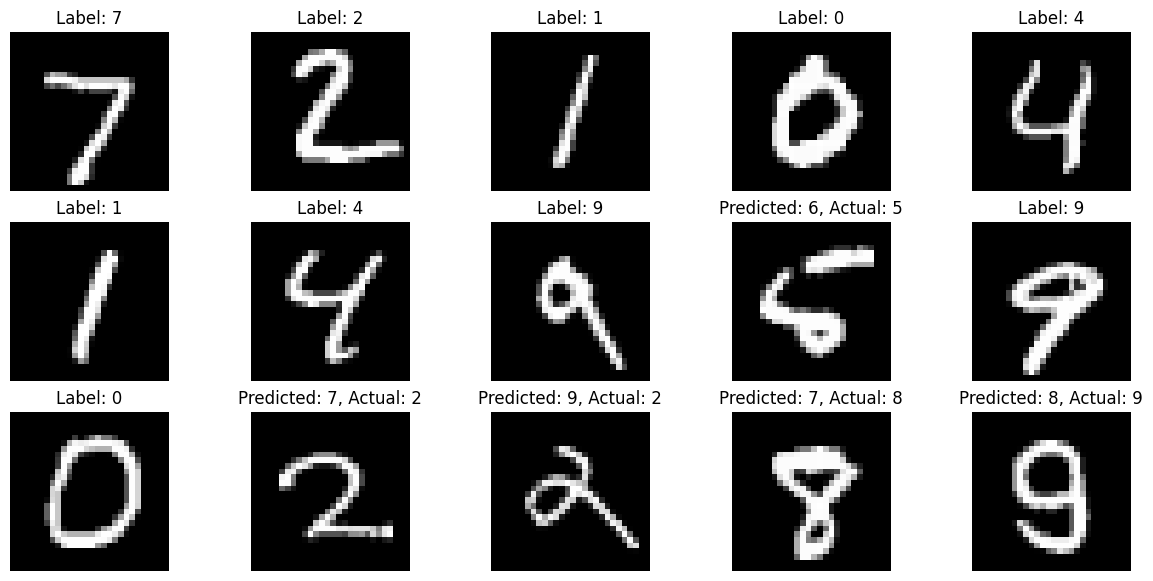

In [13]:
num_present = 10
num_wrong = 5
fig, axes = plt.subplots(3, 5, figsize=(15, 7))
index = 0
for image, label in test_dataset:
    image = image.unsqueeze(0).to(device)
    outputs = mNISTClassifier_MLP(image)
    _, predicted = torch.max(outputs.data, 1)
    if predicted.item() == label:
        if num_present > 0:
            # Present correct predictions
            axes[index//5][index%5].imshow(image.squeeze(), cmap='gray')
            axes[index//5][index%5].set_title(f'Label: {label}')
            axes[index//5][index%5].axis('off')
            index += 1
            num_present -= 1
    else:
        if num_wrong > 0:
            # Present wrong predictions
            axes[index//5][index%5].imshow(image.squeeze(), cmap='gray')
            axes[index//5][index%5].set_title(f'Predicted: {predicted.item()}, Actual: {label}')
            axes[index//5][index%5].axis('off')
            index += 1
            num_wrong -= 1
    if num_present == 0 and num_wrong == 0:
        break
plt.show()


The test dataset will give us the opportunity to evaluate the model's performance on unseen data. By analyzing the predictions made by the model, we can gain insights into its strengths and weaknesses, and identify areas for improvement.

In [14]:
mNISTClassifier_MLP.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mNISTClassifier_MLP(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 95.21%


# With a second hidden layer

In [26]:
import torch.nn as nn

class MNISTClassifier_MLP_WithHiddenLayer(nn.Module):
    def __init__(self):
        super(MNISTClassifier_MLP_WithHiddenLayer, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 64)   # Input layer to hidden layer
        self.relu = nn.ReLU()                # Rectified Linear Unit activation - fancy name for f(x) := (x>0 ? x : 0)
        self.fc2 = nn.Linear(64, 16)       # Input layer to hidden layer
        self.fc3 = nn.Linear(16, 10)        # Hidden layer to output layer (10 classes)

    def forward(self, x):
        x = self.flatten(x)         # Flatten 28x28 to 784
        x = self.fc1(x)             # Apply first linear layer
        x = self.relu(x)            # Apply ReLU activation
        x = self.fc2(x)             # Apply second linear layer
        x = self.relu(x)            # Apply ReLU activation
        x = self.fc3(x)             # Apply third linear layer
        return x

mNISTClassifier_MLP_WithHiddenLayer = MNISTClassifier_MLP_WithHiddenLayer()
for name, param in mNISTClassifier_MLP_WithHiddenLayer.named_parameters():
    if param.requires_grad:
        print(f"Trainable parameter: {name}, Size: {param.data.size()}")
    else:
        print(f"Non-trainable parameter: {name}, Size: {param.data.size()}")

Trainable parameter: fc1.weight, Size: torch.Size([64, 784])
Trainable parameter: fc1.bias, Size: torch.Size([64])
Trainable parameter: fc2.weight, Size: torch.Size([16, 64])
Trainable parameter: fc2.bias, Size: torch.Size([16])
Trainable parameter: fc3.weight, Size: torch.Size([10, 16])
Trainable parameter: fc3.bias, Size: torch.Size([10])


The following code should take 13 seconds to run

In [27]:
# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mNISTClassifier_MLP_WithHiddenLayer.to(device)
# Define loss function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mNISTClassifier_MLP_WithHiddenLayer.parameters(), lr=0.001)
num_epochs = 2

for epoch in range(num_epochs):
    mNISTClassifier_MLP_WithHiddenLayer.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mNISTClassifier_MLP_WithHiddenLayer(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

mNISTClassifier_MLP_WithHiddenLayer.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mNISTClassifier_MLP_WithHiddenLayer(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 93.25%


# With a different optimizer

In [28]:
mNISTClassifier_MLP_DifferentOptimizer = MNISTClassifier_MLP()
# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mNISTClassifier_MLP_DifferentOptimizer.to(device)
# Define loss function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
# Using a different optimizer
optimizerSGD = optim.SGD(mNISTClassifier_MLP_DifferentOptimizer.parameters(), lr=0.01, momentum=0.9)
num_epochs = 2

for epoch in range(num_epochs):
    mNISTClassifier_MLP_DifferentOptimizer.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizerSGD.zero_grad()
        outputs = mNISTClassifier_MLP_DifferentOptimizer(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizerSGD.step()

mNISTClassifier_MLP_DifferentOptimizer.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mNISTClassifier_MLP_DifferentOptimizer(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 92.13%


The accuracy seems to have decreased with the different optimizer.

# Returning to the original model with more epochs

In [29]:

mNISTClassifier_MLP_MoreEpochs = MNISTClassifier_MLP()
mNISTClassifier_MLP_MoreEpochs.to(device)
# Define loss function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mNISTClassifier_MLP_MoreEpochs.parameters(), lr=0.001)
num_epochs = 4

for epoch in range(num_epochs):
    mNISTClassifier_MLP_MoreEpochs.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mNISTClassifier_MLP_MoreEpochs(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
mNISTClassifier_MLP_MoreEpochs.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mNISTClassifier_MLP_MoreEpochs(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 88.85%


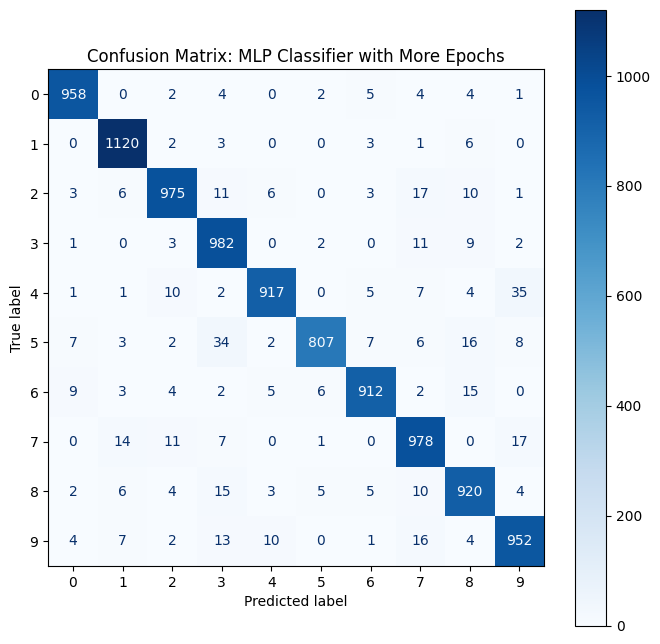

In [17]:
# Display confusion matrix of mNISTClassifier_MLP_MoreEpochs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get all predictions and true labels
all_preds = []
all_labels = []
mNISTClassifier_MLP.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mNISTClassifier_MLP(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix: MLP Classifier with More Epochs")
plt.show()

# Saving and Loading Models

Now that we've trained several models, we can save them to files so we can use them later in the interactive notebook.

In [ ]:
import os
import json

# Create a models directory if it doesn't exist
models_dir = './models'
os.makedirs(models_dir, exist_ok=True)

def save_model(model, model_name, accuracy):
    """
    Save a PyTorch model and its metadata to a file.
    
    Args:
        model: The PyTorch model to save
        model_name: Name for the model file (will be prefixed with 'model_')
        accuracy: The test accuracy of the model
    """
    # Save the model state dictionary
    model_path = os.path.join(models_dir, f'model_{model_name}.pt')
    torch.save(model.state_dict(), model_path)
    
    # Save metadata as JSON
    metadata = {
        'name': model_name,
        'accuracy': accuracy,
        'model_class': model.__class__.__name__,
        'timestamp': str(np.datetime64('today'))
    }
    
    metadata_path = os.path.join(models_dir, f'model_{model_name}_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    
    print(f"Model saved as: {model_path}")
    print(f"Metadata saved as: {metadata_path}")

# Save the MLP model (the best performer with 95.21% accuracy)
save_model(mNISTClassifier_MLP, 'mlp_adam_2epochs', 95.21)

# Save the MLP with hidden layer
save_model(mNISTClassifier_MLP_WithHiddenLayer, 'mlp_hidden_2epochs', 93.25)

# Save the MLP with different optimizer
save_model(mNISTClassifier_MLP_DifferentOptimizer, 'mlp_sgd_2epochs', 92.13)

# Save the MLP with more epochs
save_model(mNISTClassifier_MLP_MoreEpochs, 'mlp_adam_4epochs', 88.85)

# List saved models
print("\nSaved models:")
for file in sorted(os.listdir(models_dir)):
    if file.endswith('_metadata.json'):
        with open(os.path.join(models_dir, file), 'r') as f:
            metadata = json.load(f)
            print(f"  - {metadata['name']}: {metadata['accuracy']}% accuracy")